# Subtype predictor -- single cell QC

In this file I will QC the HGSC single cell data from 

cell type calls are from the authors

data is from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE192898


manuscript of data: Longitudinal single-cell RNA-seq analysis reveals stress-promoted chemoresistance in metastatic ovarian cancer

I will make the typical QC plots, then write it out for making pseudobulks

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib.pyplot import rc_context

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

data_path = f"{os.getcwd()}/../../data/single_cell/"

result_ad_file = f"{data_path}/GSE192898_processed/GSE192898_processed.h5ad"


2025-01-08 19:18:32.788856: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 19:18:32.789615: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 19:18:32.791829: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-08 19:18:32.797323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736389112.805901 2549816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736389112.80

scanpy==1.10.4 anndata==0.8.0 umap==0.5.2 numpy==1.26.0 scipy==1.14.1 pandas==1.5.3 scikit-learn==1.6.0 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [2]:
# read in the expression
expr_df = pd.read_csv(f"{data_path}/GSE192898_RAW/GSE192898_Ovarian_Cancer_raw_UMI_matrix.tsv.gz", index_col=0, sep="\t")



In [3]:
expr_df

AAACCTGAGTCCGTAT-1  AAACCTGCAGGGTACA-1  AAACCTGTCAATCTCT-1  \
Gene_symbol                                                               
A1BG                          1                   1                   0   
A1BG-AS1                      0                   0                   0   
A2M                           0                  14                   0   
A2M-AS1                       0                   0                   0   
A2ML1                         0                   0                   0   
...                         ...                 ...                 ...   
ZXDC                          0                   0                   0   
ZYG11A                        0                   0                   0   
ZYG11B                        0                   0                   0   
ZYX                           3                  13                   0   
ZZEF1                         0                   0                   0   

             AAACCTGTCACAAACC-1  AAACCTGTCACGATGT-1  AAACCTGTCGTTACAG-1  \
Gene_symbol                                                               
A1BG                          0                   0                   0   
A1BG-AS1                      0                   0                   0   
A2M                           0                   0                   0   
A2M-AS1                       0                   0                   0   
A2ML1                         0                   0                   0   
...                         ...                 ...                 ...   
ZXDC                          0                   0                   0   
ZYG11A                        0                   0                   0   
ZYG11B                        0                   0                   1   
ZYX                           2                   2                   6   
ZZEF1                         0                   0                   0   

             AAACGGGAGTGAACAT-1  AAACGGGCAGAAGCAC-1  AAACGGGCATGCAATC-1  \
Gene_symbol                                                               
A1BG                          0                  14                   0   
A1BG-AS1                      0                   0                   0   
A2M                           1                   0                   0   
A2M-AS1                       0                   0                   0   
A2ML1                         0                   0                   0   
...                         ...                 ...                 ...   
ZXDC                          2                   0                   0   
ZYG11A                        0                   0                   0   
ZYG11B                        0                   1                   0   
ZYX                          16                  17                   0   
ZZEF1                         0                   0                   0   

             AAAGATGAGAGATGAG-1  ...  TTTGGTTAGTTCCACA-1  TTTGGTTCAGGTCCAC-1  \
Gene_symbol                      ...                                           
A1BG                          0  ...                   0                   0   
A1BG-AS1                      0  ...                   0                   0   
A2M                           0  ...                   8                   0   
A2M-AS1                       0  ...                   0                   0   
A2ML1                         0  ...                   0                   0   
...                         ...  ...                 ...                 ...   
ZXDC                          0  ...                   0                   0   
ZYG11A                        0  ...                   0                   0   
ZYG11B                        0  ...                   0                   0   
ZYX                           1  ...                   5                   0   
ZZEF1                         0  ...                   0                   0   

             TTTGGTTGTCCGCTGA-1.1  TTTGGTTGT

In [4]:
# make anndata
expr_df = expr_df.T
all_adata = ad.AnnData(X=expr_df.values, obs=pd.DataFrame(index=expr_df.index), var=pd.DataFrame(index=expr_df.columns))
all_adata

/tmp/ipykernel_2549816/2101416292.py:3: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  all_adata = ad.AnnData(X=expr_df.values, obs=pd.DataFrame(index=expr_df.index), var=pd.DataFrame(index=expr_df.columns))


AnnData object with n_obs × n_vars = 18299 × 26906

# format metadata

In [7]:
# read in the metadata
meta_cell_path = f"{data_path}/GSE192898_metadata/GSE192898_Ovarian_Cancer_cell_annotation.tsv"

# read in tables
merged_df = pd.read_csv(meta_cell_path, sep="\t")


# merge the metadata
merged_df["Barcode"] = merged_df["Index"]
merged_df.index = merged_df["Barcode"]

# remove duplicates
cell_barcode_keep = pd.Series(merged_df["Barcode"]).drop_duplicates(keep=False)
merged_df = merged_df.iloc[np.where(merged_df["Barcode"].isin(cell_barcode_keep))[0]]
all_adata = all_adata[np.where(all_adata.obs.index.isin(cell_barcode_keep))[0],:]

# order the obs in the same order
merged_df.index = merged_df["Barcode"]
left_df, right_df = merged_df.align(all_adata.obs, join="inner", axis=0)
left_df

merged_df.index = merged_df["Barcode"]

#inner: use intersection of keys from both frames, preserve the order of the left keys.
left_df, right_df = all_adata.obs.align(merged_df, join="inner", axis=0)

# now keeping the same ordering as the original obs
# replace the obs DF
all_adata = all_adata[left_df.index, :]
all_adata.obs = right_df


In [8]:
all_adata.obs

Index   Patient   Class    Sample  \
Barcode                                                              
AAACCTGAGTCCGTAT-1  AAACCTGAGTCCGTAT-1  ovCHA004  Normal  ovCHA004   
AAACCTGCAGGGTACA-1  AAACCTGCAGGGTACA-1  ovCHA004  Normal  ovCHA004   
AAACCTGTCAATCTCT-1  AAACCTGTCAATCTCT-1  ovCHA004  Normal  ovCHA004   
AAACCTGTCACAAACC-1  AAACCTGTCACAAACC-1  ovCHA004  Normal  ovCHA004   
AAACCTGTCACGATGT-1  AAACCTGTCACGATGT-1  ovCHA004  Normal  ovCHA004   
...                                ...       ...     ...       ...   
TTTGTCACAGCTGTAT-1  TTTGTCACAGCTGTAT-1  ovCHA070  Normal  ovCHA070   
TTTGTCAGTGAGTGAC-1  TTTGTCAGTGAGTGAC-1  ovCHA070  Normal  ovCHA070   
TTTGTCAGTTACGGAG-1  TTTGTCAGTTACGGAG-1  ovCHA070  Normal  ovCHA070   
TTTGTCAGTTATGTGC-1  TTTGTCAGTTATGTGC-1  ovCHA070  Normal  ovCHA070   
TTTGTCATCGACCAGC-1  TTTGTCATCGACCAGC-1  ovCHA070  Normal  ovCHA070   

                         Cell_type             Barcode  
Barcode                                                 
AAACCTGAGTCCGTAT-1     CD8+_T-cell  AAACCTGAGTCCGTAT-1  
AAACCTGCAGGGTACA-1      Macrophage  AAACCTGCAGGGTACA-1  
AAACCTGTCAATCTCT-1     CD4+_T-cell  AAACCTGTCAATCTCT-1  
AAACCTGTCACAAACC-1     CD4+_T-cell  AAACCTGTCACAAACC-1  
AAACCTGTCACGATGT-1      Fibroblast  AAACCTGTCACGATGT-1  
...                            ...                 ...  
TTTGTCACAGCTGTAT-1  Mesangial_cell  TTTGTCACAGCTGTAT-1  
TTTGTCAGTGAGTGAC-1         NK_cell  TTTGTCAGTGAGTGAC-1  
TTTGTCAGTTACGGAG-1      Fibroblast  TTTGTCAGTTACGGAG-1  
TTTGTCAGTTATGTGC-1  Mesangial_cell  TTTGTCAGTTATGTGC-1  
TTTGTCATCGACCAGC-1      Fibroblast  TTTGTCATCGACCAGC-1  

[17910 rows x 6 columns]

In [10]:
all_adata.obs.Cell_type.value_counts()

Tumor_cell          5438
CD8+_T-cell         3193
CD4+_T-cell         1791
Fibroblast          1613
Monocyte            1552
B-cell              1528
Macrophage          1283
Endothelial_cell     393
Mesangial_cell       338
NK_cell              323
Astrocyte            155
Adipocyte            114
DC                    88
HSC                   45
Erythrocyte           26
Pericyte               9
Keratinocyte           8
Myocyte                4
Chondrocyte            4
Skeletal_muscle        3
Melanocyte             1
Smooth_muscle          1
Name: Cell_type, dtype: int64

In [14]:
tab = all_adata.obs.groupby(['Cell_type', 'Sample']).size()
tab.unstack()

Sample            ovCHA004  ovCHA017  ovCHA018  ovCHA034  ovCHA039  ovCHA066  \
Cell_type                                                                      
Adipocyte             12.0       NaN       2.0       NaN       NaN       9.0   
Astrocyte             98.0       5.0       8.0       3.0       2.0       3.0   
B-cell                73.0     147.0     225.0      11.0       6.0     481.0   
CD4+_T-cell          361.0     149.0     280.0      89.0       8.0     406.0   
CD8+_T-cell          525.0     201.0    1075.0     187.0      14.0     563.0   
Chondrocyte            1.0       NaN       NaN       1.0       NaN       NaN   
DC                     4.0       9.0      20.0       7.0       NaN      27.0   
Endothelial_cell      81.0       9.0      26.0       6.0      53.0      30.0   
Erythrocyte            NaN      11.0       7.0       NaN       3.0       5.0   
Fibroblast           437.0      58.0      47.0      35.0      86.0      23.0   
HSC                    1.0       8.0      10.0       2.0       NaN      12.0   
Keratinocyte           1.0       2.0       NaN       2.0       1.0       2.0   
Macrophage            43.0      47.0     480.0      78.0      12.0     258.0   
Melanocyte             NaN       NaN       NaN       NaN       NaN       1.0   
Mesangial_cell        21.0      16.0      28.0      24.0       4.0       9.0   
Monocyte             104.0     139.0     240.0      49.0      22.0      92.0   
Myocyte                2.0       NaN       NaN       NaN       2.0       NaN   
NK_cell               43.0      15.0      93.0      19.0       9.0      50.0   
Pericyte               7.0       1.0       NaN       1.0       NaN       NaN   
Skeletal_muscle        1.0       NaN       NaN       NaN       NaN       NaN   
Smooth_muscle          NaN       NaN       NaN       NaN       NaN       NaN   
Tumor_cell           243.0     313.0     633.0    1400.0    1413.0     391.0   

Sample            ovCHA070  ovCHA107  ovCHA110  
Cell_type                                       
Adipocyte             72.0       NaN      19.0  
Astrocyte             25.0       NaN      11.0  
B-cell                29.0     534.0      22.0  
CD4+_T-cell          104.0     339.0      55.0  
CD8+_T-cell          253.0     259.0     116.0  
Chondrocyte            2.0       NaN       NaN  
DC                     4.0       6.0      11.0  
Endothelial_cell      84.0       1.0     103.0  
Erythrocyte            NaN       NaN       NaN  
Fibroblast           730.0      11.0     186.0  
HSC                   11.0       1.0       NaN  
Keratinocyte           NaN       NaN       NaN  
Macrophage            92.0       4.0     269.0  
Melanocyte             NaN       NaN       NaN  
Mesangial_cell       224.0       1.0      11.0  
Monocyte             251.0      22.0     633.0  
Myocyte                NaN       NaN       NaN  
NK_cell               42.0       5.0      47.0  
Pericyte               NaN       NaN       NaN  
Skeletal_muscle        1.0       NaN       1.0  
Smooth_muscle          1.0       NaN       NaN  
Tumor_cell           253.0      17.0     775.0

In [16]:
# remove low count cells 
ct_idx = all_adata.obs.Cell_type.isin(["Smooth_muscle", "Skeletal_muscle", "Pericyte",
                                          "Myocyte", "Mesangial_cell", "Melanocyte", "Keratinocyte",
                                          "HSC", "Erythrocyte", "DC", "Chondrocyte", "Astrocyte",
                                          "Adipocyte"])
inverted_list = [not x for x in ct_idx]
all_adata = all_adata[np.where(inverted_list)[0]]

tab = all_adata.obs.groupby(['Cell_type', 'Sample']).size()
tab.unstack()

Sample            ovCHA004  ovCHA017  ovCHA018  ovCHA034  ovCHA039  ovCHA066  \
Cell_type                                                                      
B-cell                  73       147       225        11         6       481   
CD4+_T-cell            361       149       280        89         8       406   
CD8+_T-cell            525       201      1075       187        14       563   
Endothelial_cell        81         9        26         6        53        30   
Fibroblast             437        58        47        35        86        23   
Macrophage              43        47       480        78        12       258   
Monocyte               104       139       240        49        22        92   
NK_cell                 43        15        93        19         9        50   
Tumor_cell             243       313       633      1400      1413       391   

Sample            ovCHA070  ovCHA107  ovCHA110  
Cell_type                                       
B-cell                  29       534        22  
CD4+_T-cell            104       339        55  
CD8+_T-cell            253       259       116  
Endothelial_cell        84         1       103  
Fibroblast             730        11       186  
Macrophage              92         4       269  
Monocyte               251        22       633  
NK_cell                 42         5        47  
Tumor_cell             253        17       775

In [17]:
# remove low sample
ct_idx = all_adata.obs.Sample.isin(["ovCHA107"])
inverted_list = [not x for x in ct_idx]
all_adata = all_adata[np.where(inverted_list)[0]]

tab = all_adata.obs.groupby(['Cell_type', 'Sample']).size()
tab.unstack()

Sample            ovCHA004  ovCHA017  ovCHA018  ovCHA034  ovCHA039  ovCHA066  \
Cell_type                                                                      
B-cell                  73       147       225        11         6       481   
CD4+_T-cell            361       149       280        89         8       406   
CD8+_T-cell            525       201      1075       187        14       563   
Endothelial_cell        81         9        26         6        53        30   
Fibroblast             437        58        47        35        86        23   
Macrophage              43        47       480        78        12       258   
Monocyte               104       139       240        49        22        92   
NK_cell                 43        15        93        19         9        50   
Tumor_cell             243       313       633      1400      1413       391   

Sample            ovCHA070  ovCHA110  
Cell_type                             
B-cell                  29        22  
CD4+_T-cell            104        55  
CD8+_T-cell            253       116  
Endothelial_cell        84       103  
Fibroblast             730       186  
Macrophage              92       269  
Monocyte               251       633  
NK_cell                 42        47  
Tumor_cell             253       775

In [21]:
# format metadata

# reformat the cell types to be more granular
cell_type_vec = all_adata.obs['Cell_type'].copy()
immune_idx = np.where(cell_type_vec.isin(["B-cell", "CD4+_T-cell", "CD8+_T-cell", "Macrophage",
                                          "Monocyte", "NK_cell"]) )[0]
cell_type_vec[immune_idx] = "immune"

stromal_idx = np.where(cell_type_vec.isin(["Endothelial_cell", "Fibroblast"]) )[0] 
cell_type_vec[stromal_idx] = "stromal"

epi_idx = np.where(cell_type_vec.isin(["Tumor_cell"]) )[0]
cell_type_vec[epi_idx] = "tumor"
all_adata.obs['celltype_granular'] = cell_type_vec

all_adata.obs['scpred_CellType'] = all_adata.obs['Cell_type']
all_adata.obs['cellType'] = all_adata.obs['Cell_type']

# remove cells with no cell type
all_adata = all_adata[np.where(~all_adata.obs.scpred_CellType.isna())[0]]

all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['Sample'].astype(str)
all_adata.obs['sample_id'] = all_adata.obs['Sample'].tolist()
all_adata.obs['stim'] = ["CTRL"]*len(all_adata.obs)


/tmp/ipykernel_2549816/2449026849.py:14: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['celltype_granular'] = cell_type_vec
/tmp/ipykernel_2549816/2449026849.py:22: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  all_adata.obs['sample_id'] = 'Samp_' + all_adata.obs['Sample'].astype(str)


In [22]:
set(all_adata.obs.scpred_CellType)

{'B-cell',
 'CD4+_T-cell',
 'CD8+_T-cell',
 'Endothelial_cell',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'NK_cell',
 'Tumor_cell'}

In [23]:
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType  B-cell  CD4+_T-cell  CD8+_T-cell  Endothelial_cell  \
sample_id                                                             
ovCHA004             73          361          525                81   
ovCHA017            147          149          201                 9   
ovCHA018            225          280         1075                26   
ovCHA034             11           89          187                 6   
ovCHA039              6            8           14                53   
ovCHA066            481          406          563                30   
ovCHA070             29          104          253                84   
ovCHA110             22           55          116               103   

scpred_CellType  Fibroblast  Macrophage  Monocyte  NK_cell  Tumor_cell  
sample_id                                                               
ovCHA004                437          43       104       43         243  
ovCHA017                 58          47       139       15         313  
ovCHA018                 47         480       240       93         633  
ovCHA034                 35          78        49       19        1400  
ovCHA039                 86          12        22        9        1413  
ovCHA066                 23         258        92       50         391  
ovCHA070                730          92       251       42         253  
ovCHA110                186         269       633       47         775

In [24]:
# remove genes that are duplicated
all_adata.var["gene_ids"] = all_adata.var.index.to_list()
a = (all_adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

all_adata = all_adata[:, all_adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
all_adata.var.index = all_adata.var['gene_ids']


# QC everything

In [25]:
# how many of each samp
all_adata.obs["sample_id"].value_counts()

ovCHA018    3099
ovCHA066    2294
ovCHA110    2206
ovCHA004    1910
ovCHA034    1874
ovCHA070    1838
ovCHA039    1623
ovCHA017    1078
Name: sample_id, dtype: int64

In [26]:
# see cell types, we will merge some
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()

tab.unstack()

scpred_CellType  B-cell  CD4+_T-cell  CD8+_T-cell  Endothelial_cell  \
sample_id                                                             
ovCHA004             73          361          525                81   
ovCHA017            147          149          201                 9   
ovCHA018            225          280         1075                26   
ovCHA034             11           89          187                 6   
ovCHA039              6            8           14                53   
ovCHA066            481          406          563                30   
ovCHA070             29          104          253                84   
ovCHA110             22           55          116               103   

scpred_CellType  Fibroblast  Macrophage  Monocyte  NK_cell  Tumor_cell  
sample_id                                                               
ovCHA004                437          43       104       43         243  
ovCHA017                 58          47       139       15         313  
ovCHA018                 47         480       240       93         633  
ovCHA034                 35          78        49       19        1400  
ovCHA039                 86          12        22        9        1413  
ovCHA066                 23         258        92       50         391  
ovCHA070                730          92       251       42         253  
ovCHA110                186         269       633       47         775

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


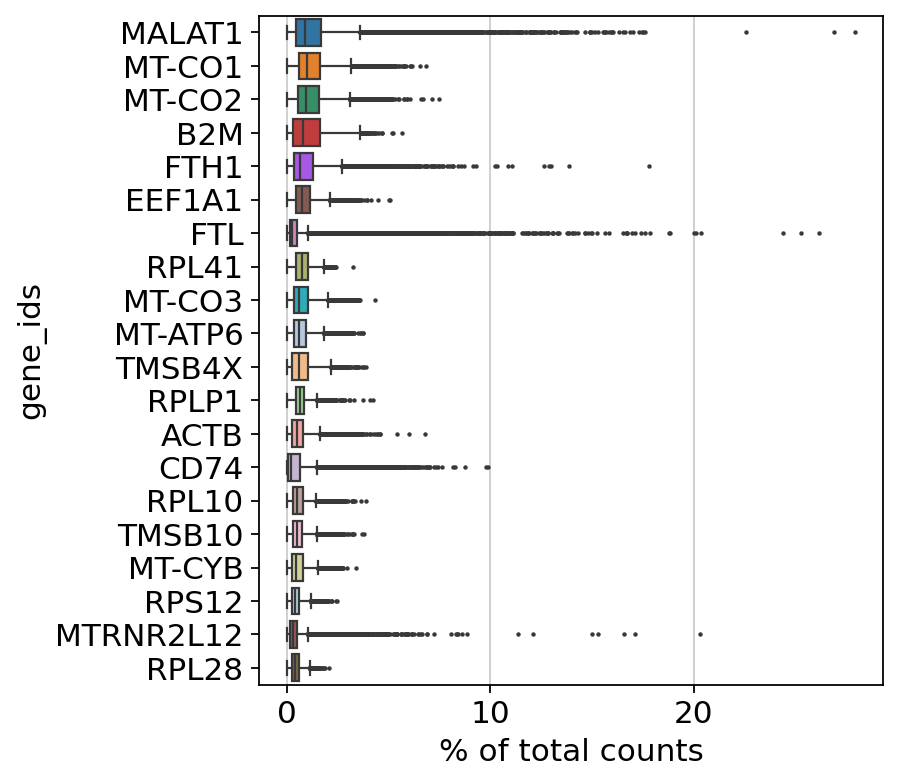

In [27]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


In [28]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(all_adata, min_genes=500)
sc.pp.filter_genes(all_adata, min_cells=3)


filtered out 10 cells that have less than 500 genes expressed
filtered out 766 genes that are detected in less than 3 cells


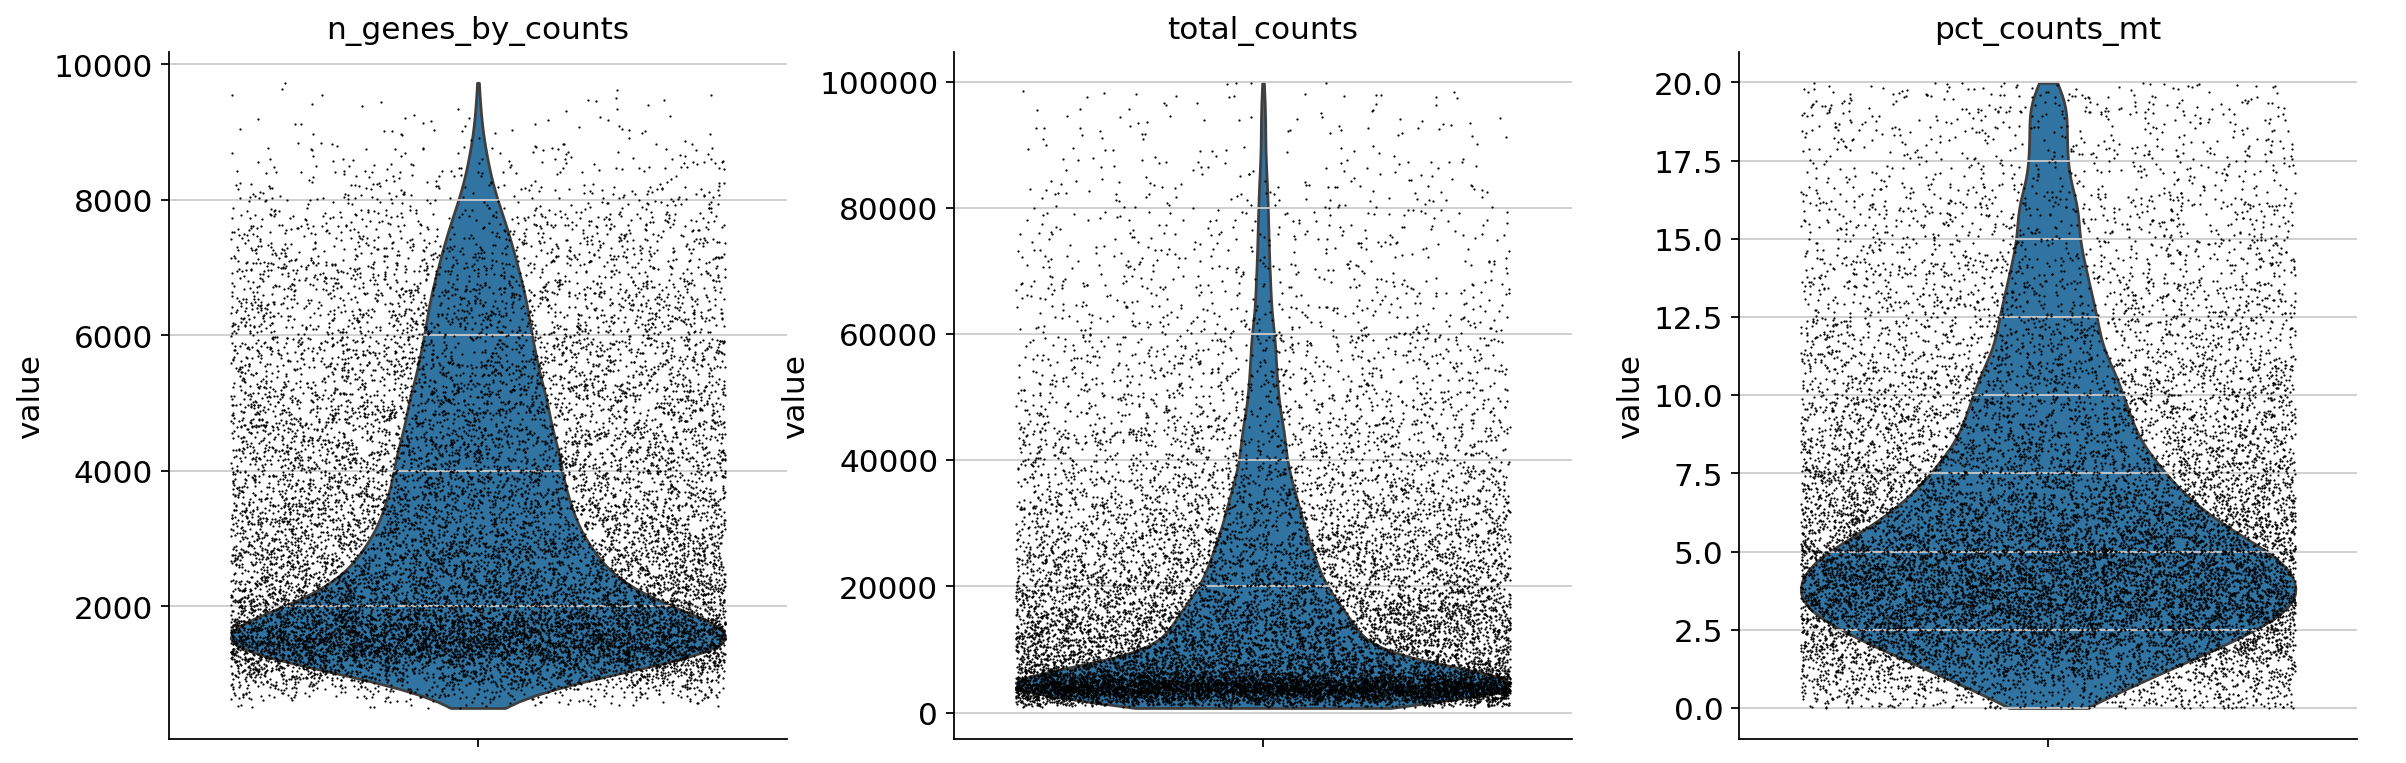

In [29]:
# remove genes with high mitochondrial content
all_adata.var['mt'] = all_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(all_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(all_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

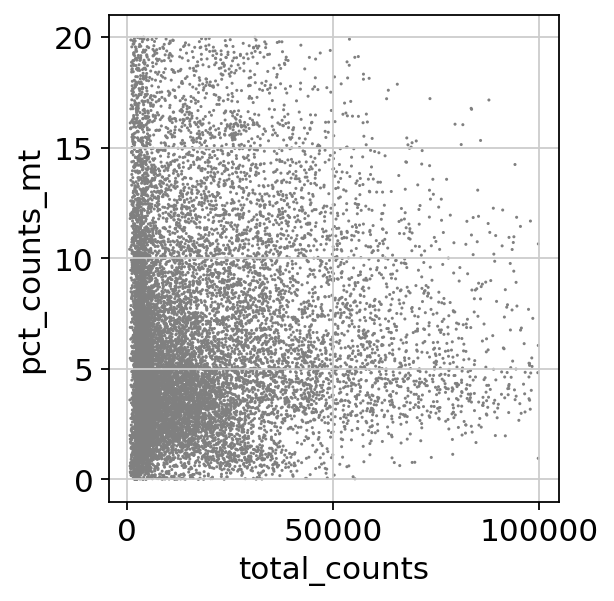

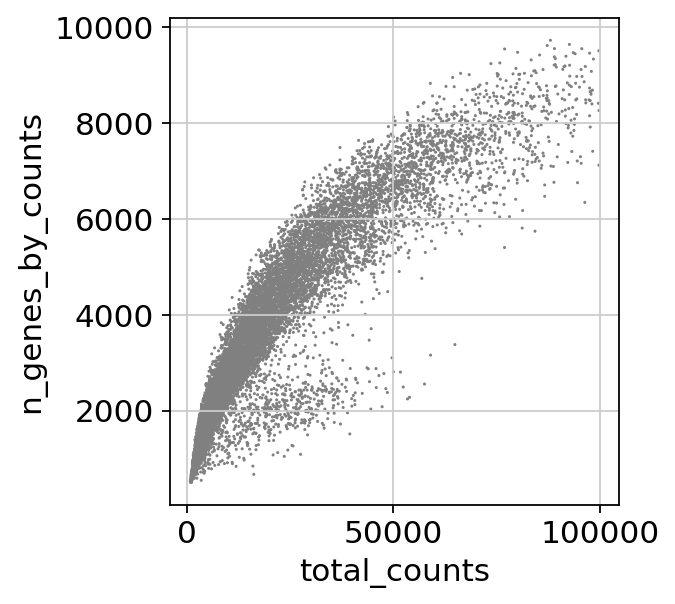

In [30]:
sc.pl.scatter(all_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(all_adata, x='total_counts', y='n_genes_by_counts')

In [31]:
# slice the data based on the plots from above
# remove cells with more than 7000 genes
# remove cells with more than 10% MTgenes
all_adata = all_adata[all_adata.obs.n_genes_by_counts < 10000, :]
all_adata = all_adata[all_adata.obs.pct_counts_mt < 15, :]

/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


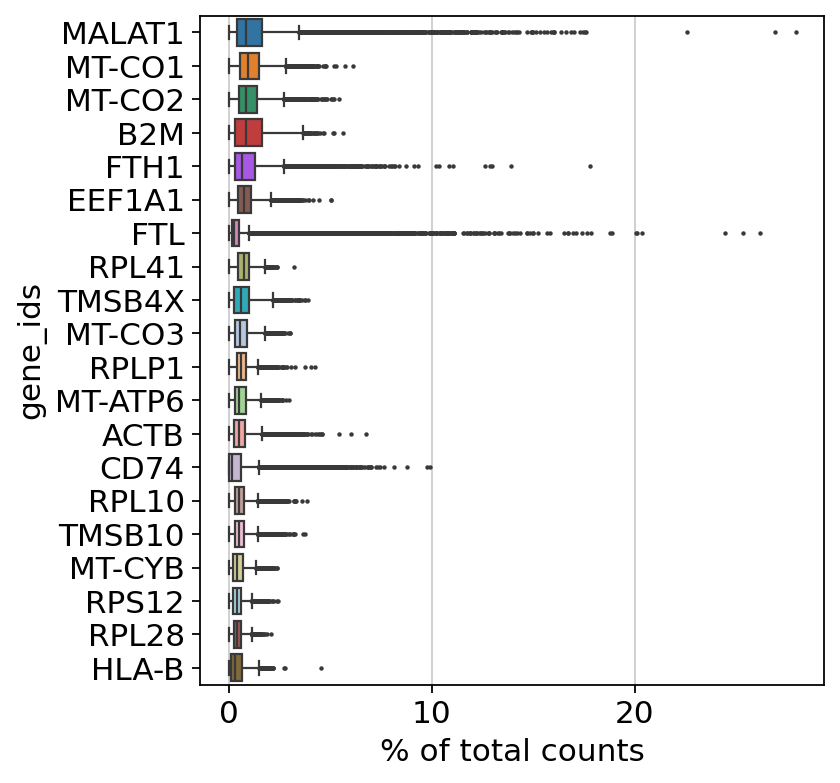

In [32]:
sc.pl.highest_expr_genes(all_adata, n_top=20, )


## write it out

In [33]:
tab = all_adata.obs.groupby(['sample_id', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType  B-cell  CD4+_T-cell  CD8+_T-cell  Endothelial_cell  \
sample_id                                                             
ovCHA004             72          354          514                77   
ovCHA017            145          148          199                 9   
ovCHA018            223          275         1056                23   
ovCHA034             11           88          180                 6   
ovCHA039              6            8           14                50   
ovCHA066            467          398          556                29   
ovCHA070             28           99          249                79   
ovCHA110             22           54          114               103   

scpred_CellType  Fibroblast  Macrophage  Monocyte  NK_cell  Tumor_cell  
sample_id                                                               
ovCHA004                423          42       101       43         200  
ovCHA017                 58          45       137       15         299  
ovCHA018                 46         440       228       92         500  
ovCHA034                 32          70        41       19        1256  
ovCHA039                 83          10        17        9        1346  
ovCHA066                 23         250        89       50         293  
ovCHA070                717          85       248       42         237  
ovCHA110                181         260       584       45         667

In [34]:
set(all_adata.obs.cellType)

{'B-cell',
 'CD4+_T-cell',
 'CD8+_T-cell',
 'Endothelial_cell',
 'Fibroblast',
 'Macrophage',
 'Monocyte',
 'NK_cell',
 'Tumor_cell'}

In [35]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/0_process_sc/../../data/single_cell//GSE192898_processed/GSE192898_processed.h5ad'

In [36]:
# write it out before normalization
all_adata.write(result_ad_file)


# Normalization

normalizing counts per cell


    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


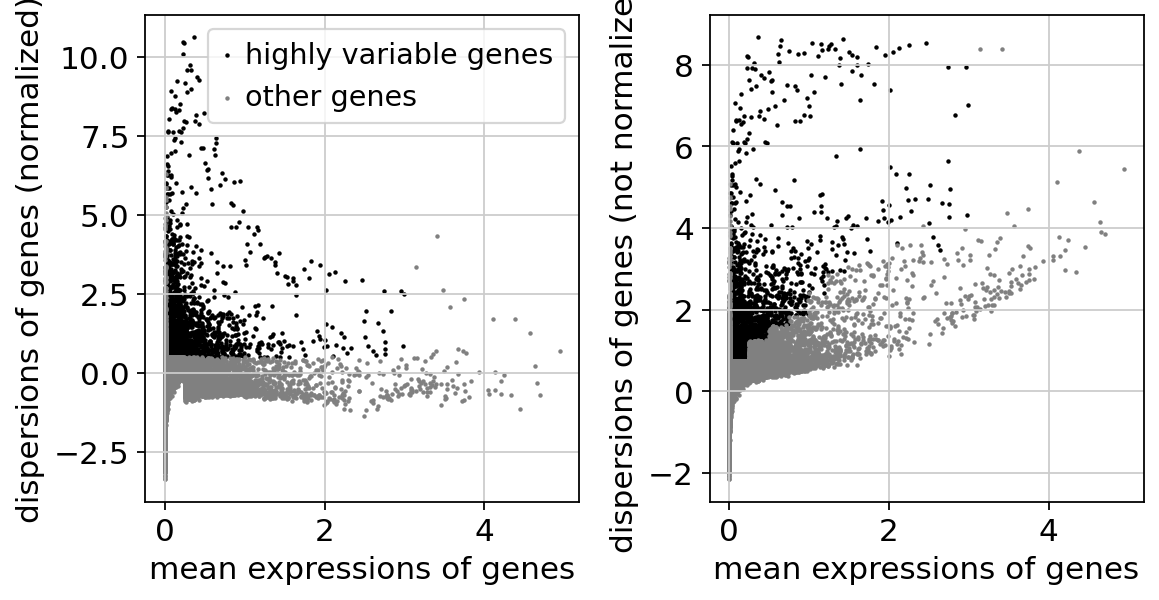

In [37]:
# normalize to 10K counts per cell
sc.pp.normalize_total(all_adata, target_sum=1e4)

# log data
sc.pp.log1p(all_adata)

# get high variance genes
sc.pp.highly_variable_genes(all_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(all_adata)

# now store the raw version of the data for our use later
all_adata.raw = all_adata


In [38]:
# now process the counts further for doing DE 
# analysis and the cell clustering
all_adata = all_adata[:, all_adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(all_adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(all_adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:34)


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# PCA

computing PCA
    with n_comps=50


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:210: UserWarning: When using a mask parameter with anndata<0.9 on a dense array, the PCAcan have slightly different results due the array being column major instead of row major.
  warnings.warn(


    finished (0:00:03)


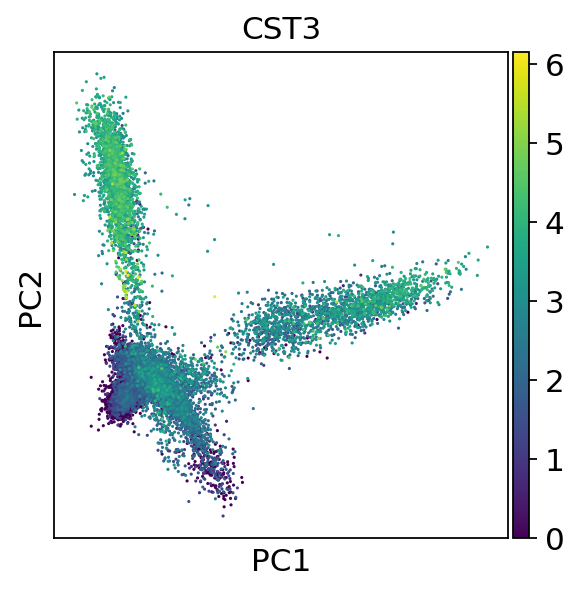

In [39]:
sc.tl.pca(all_adata, n_comps=50)
sc.pl.pca(all_adata, color='CST3')


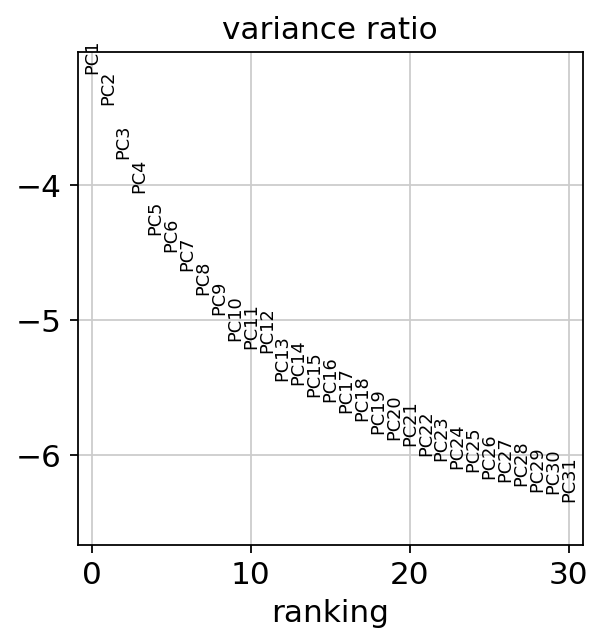

In [40]:
sc.pl.pca_variance_ratio(all_adata, log=True)


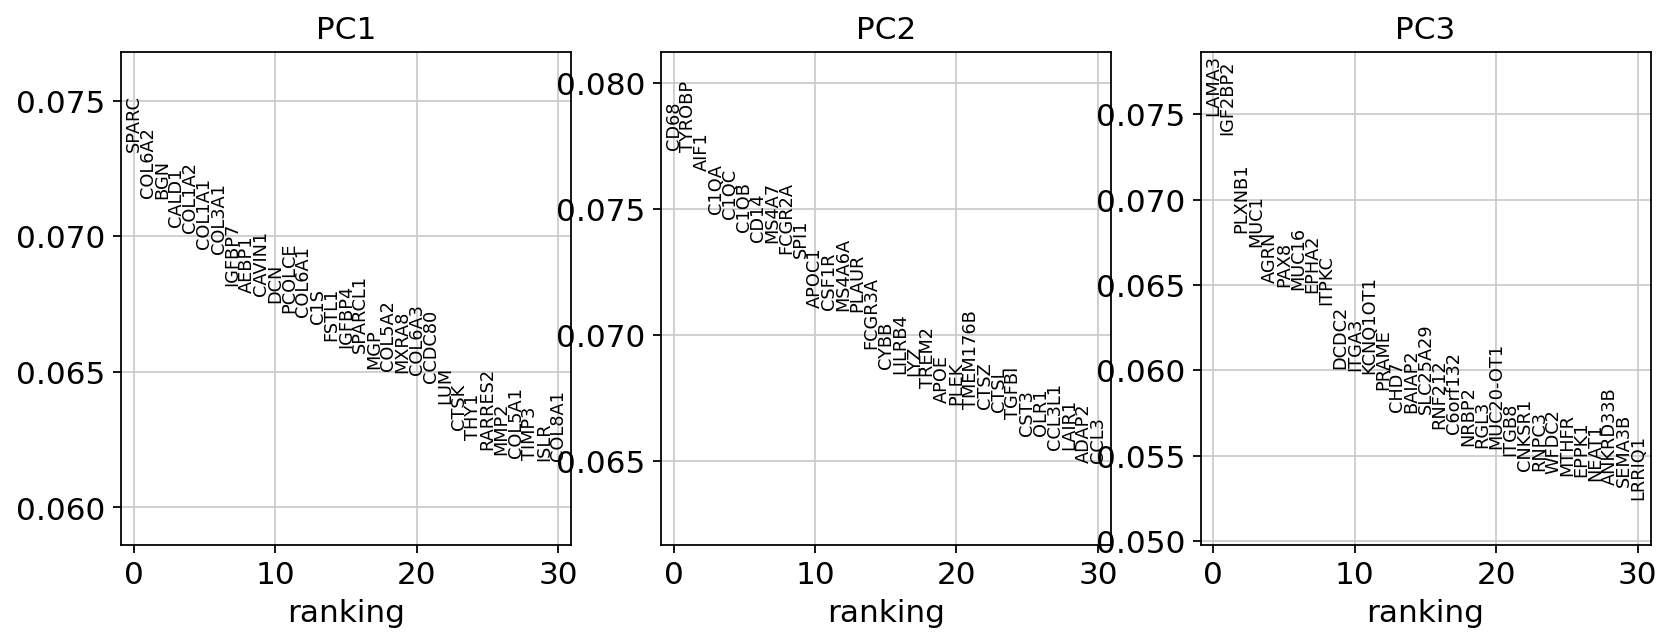

In [41]:
sc.pl.pca_loadings(all_adata, include_lowest=False)


## Compute and embed neighborhood graph

In [42]:
# valculate neighborhood graph
sc.pp.neighbors(all_adata)

# make umap
sc.tl.umap(all_adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


## Cluster the neighborhood graph

running Leiden clustering


/tmp/ipykernel_2549816/2557792080.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(all_adata, resolution=0.7)


    finished: found 27 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


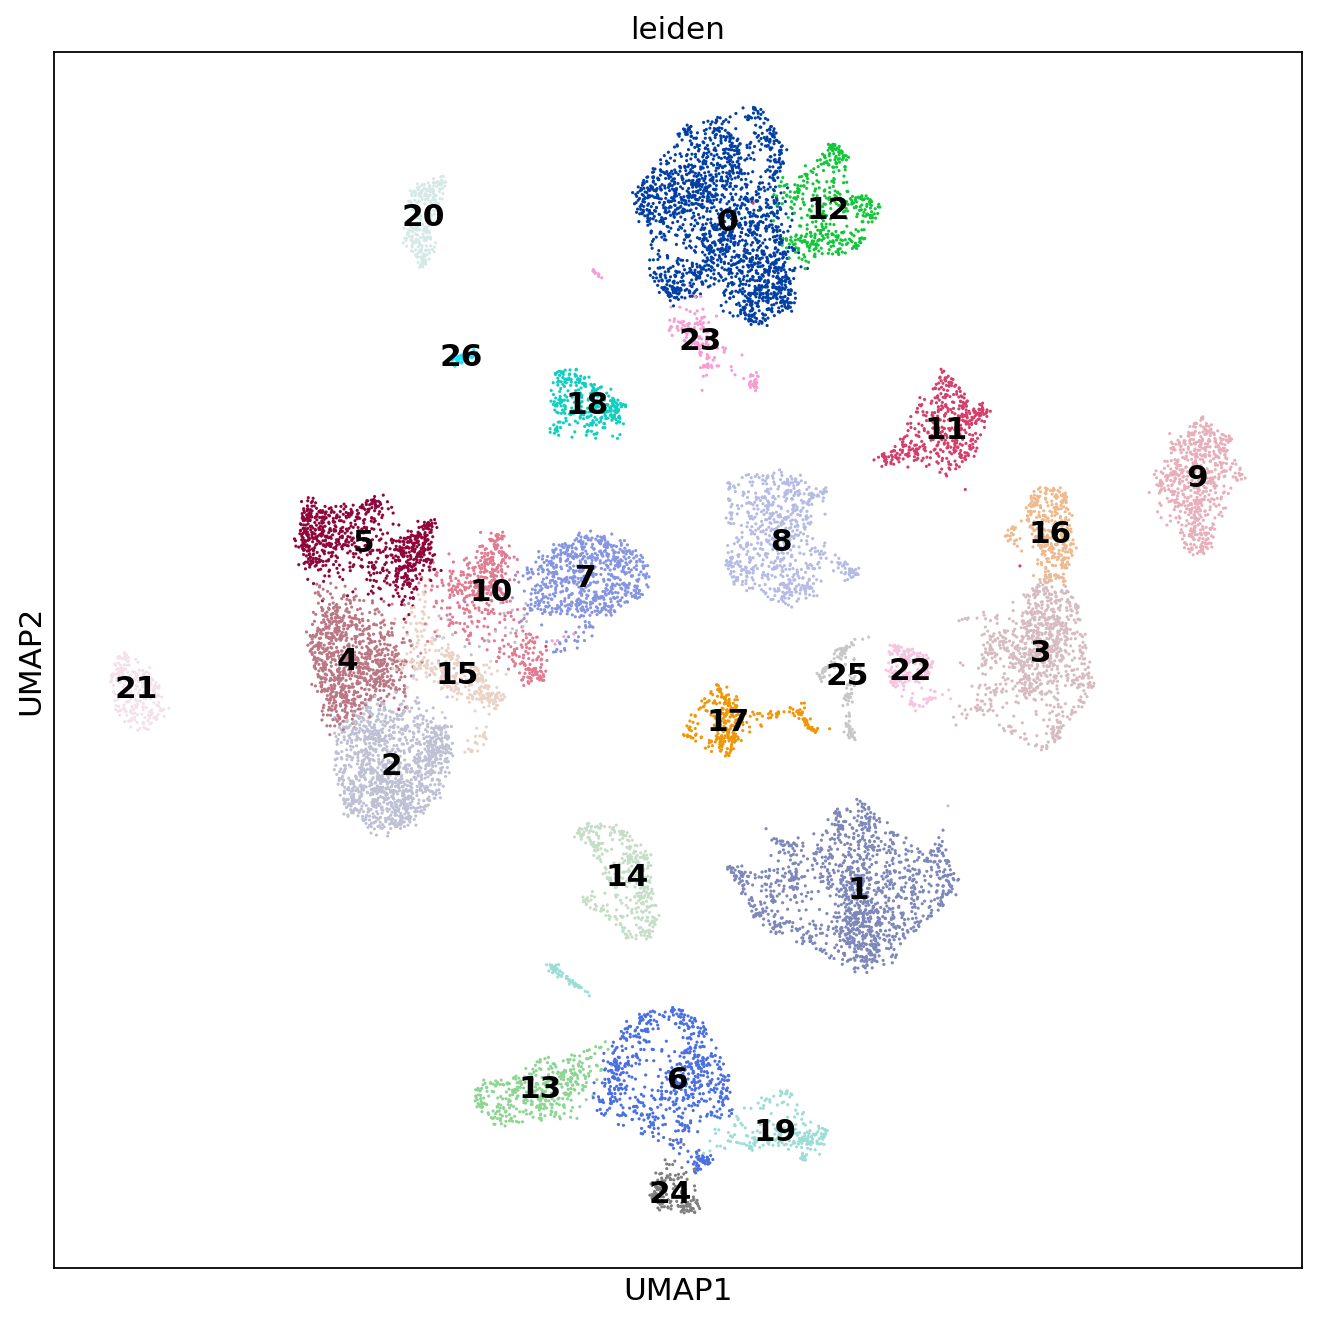

In [43]:
# lets use Leiden clustering
sc.tl.leiden(all_adata, resolution=0.7)
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='leiden', legend_loc='on data')



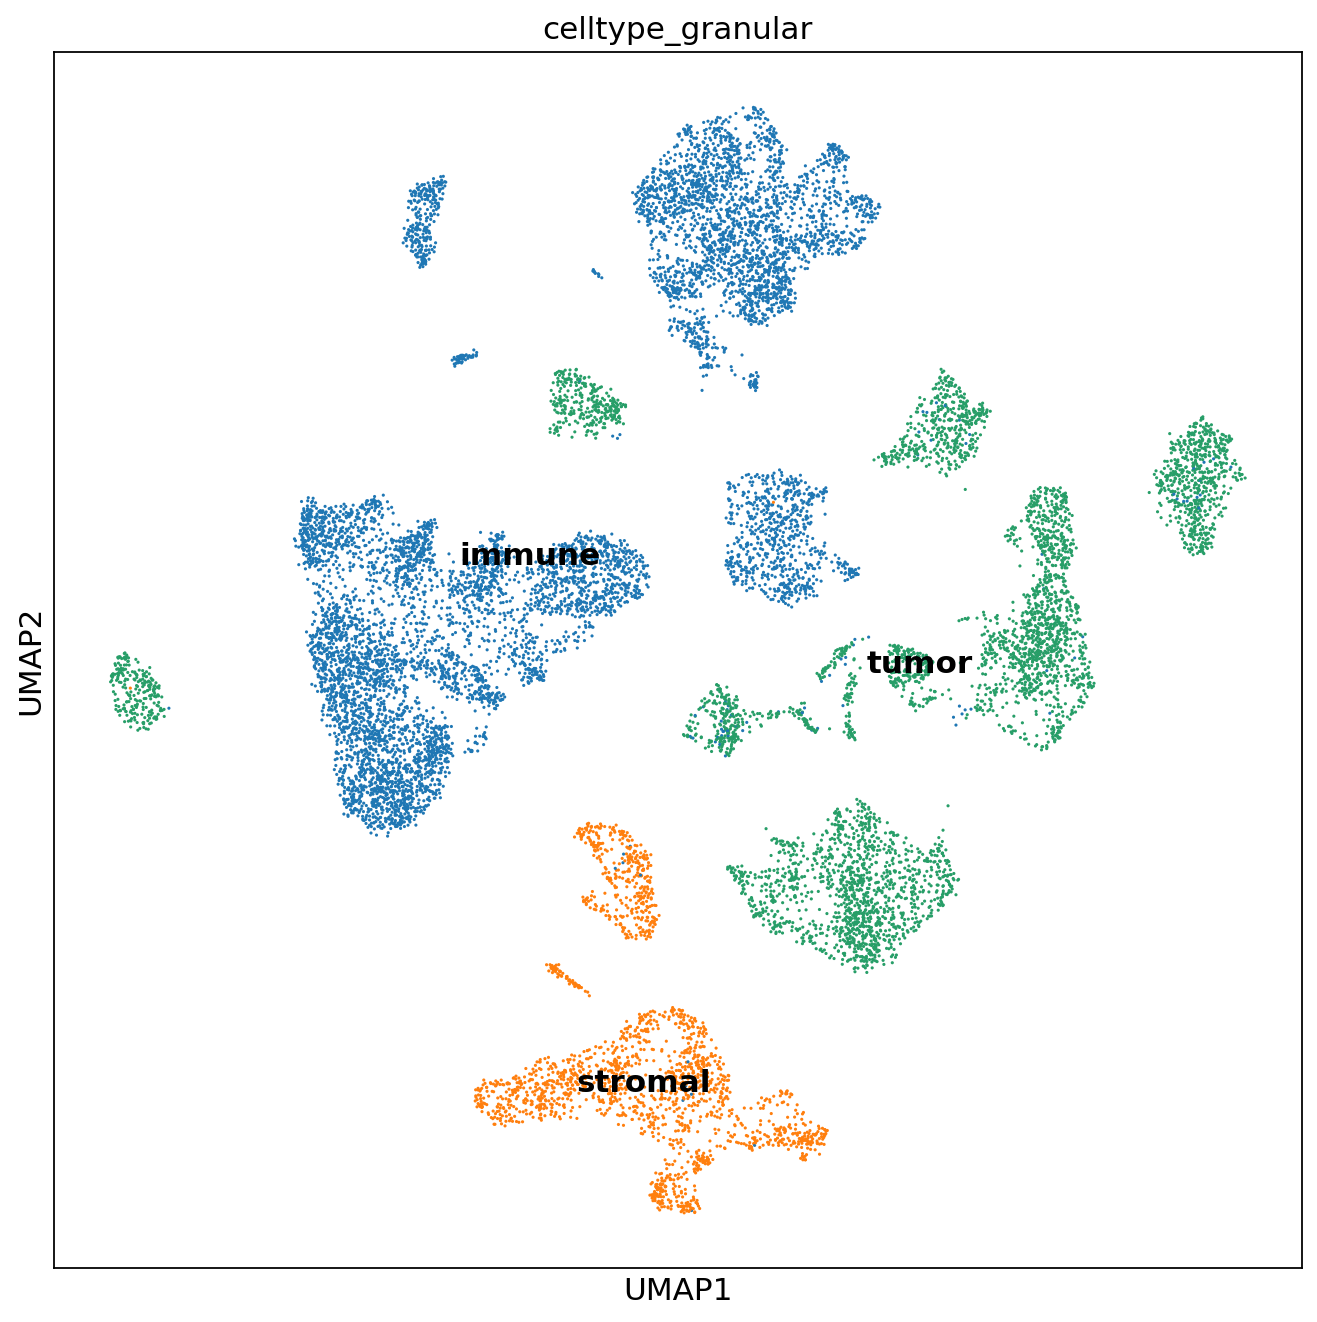

In [44]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='celltype_granular', legend_loc='on data')


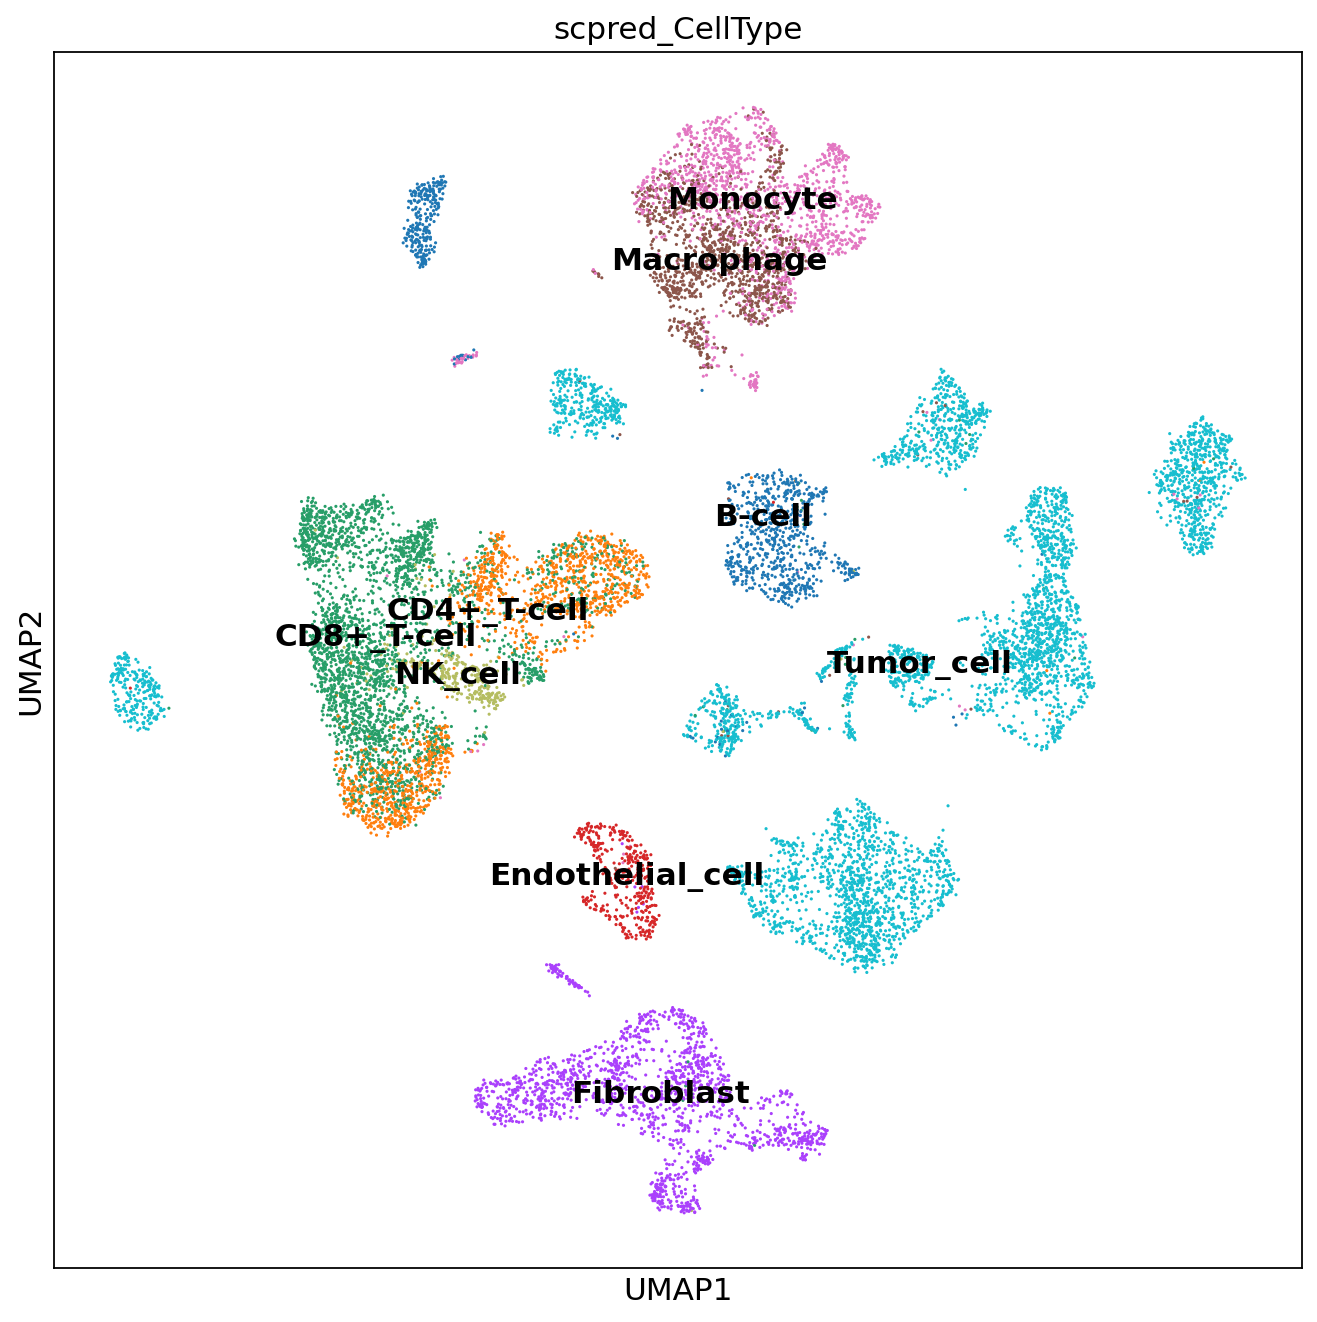

In [45]:
# lets use previously identified clustering
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='scpred_CellType', legend_loc='on data')


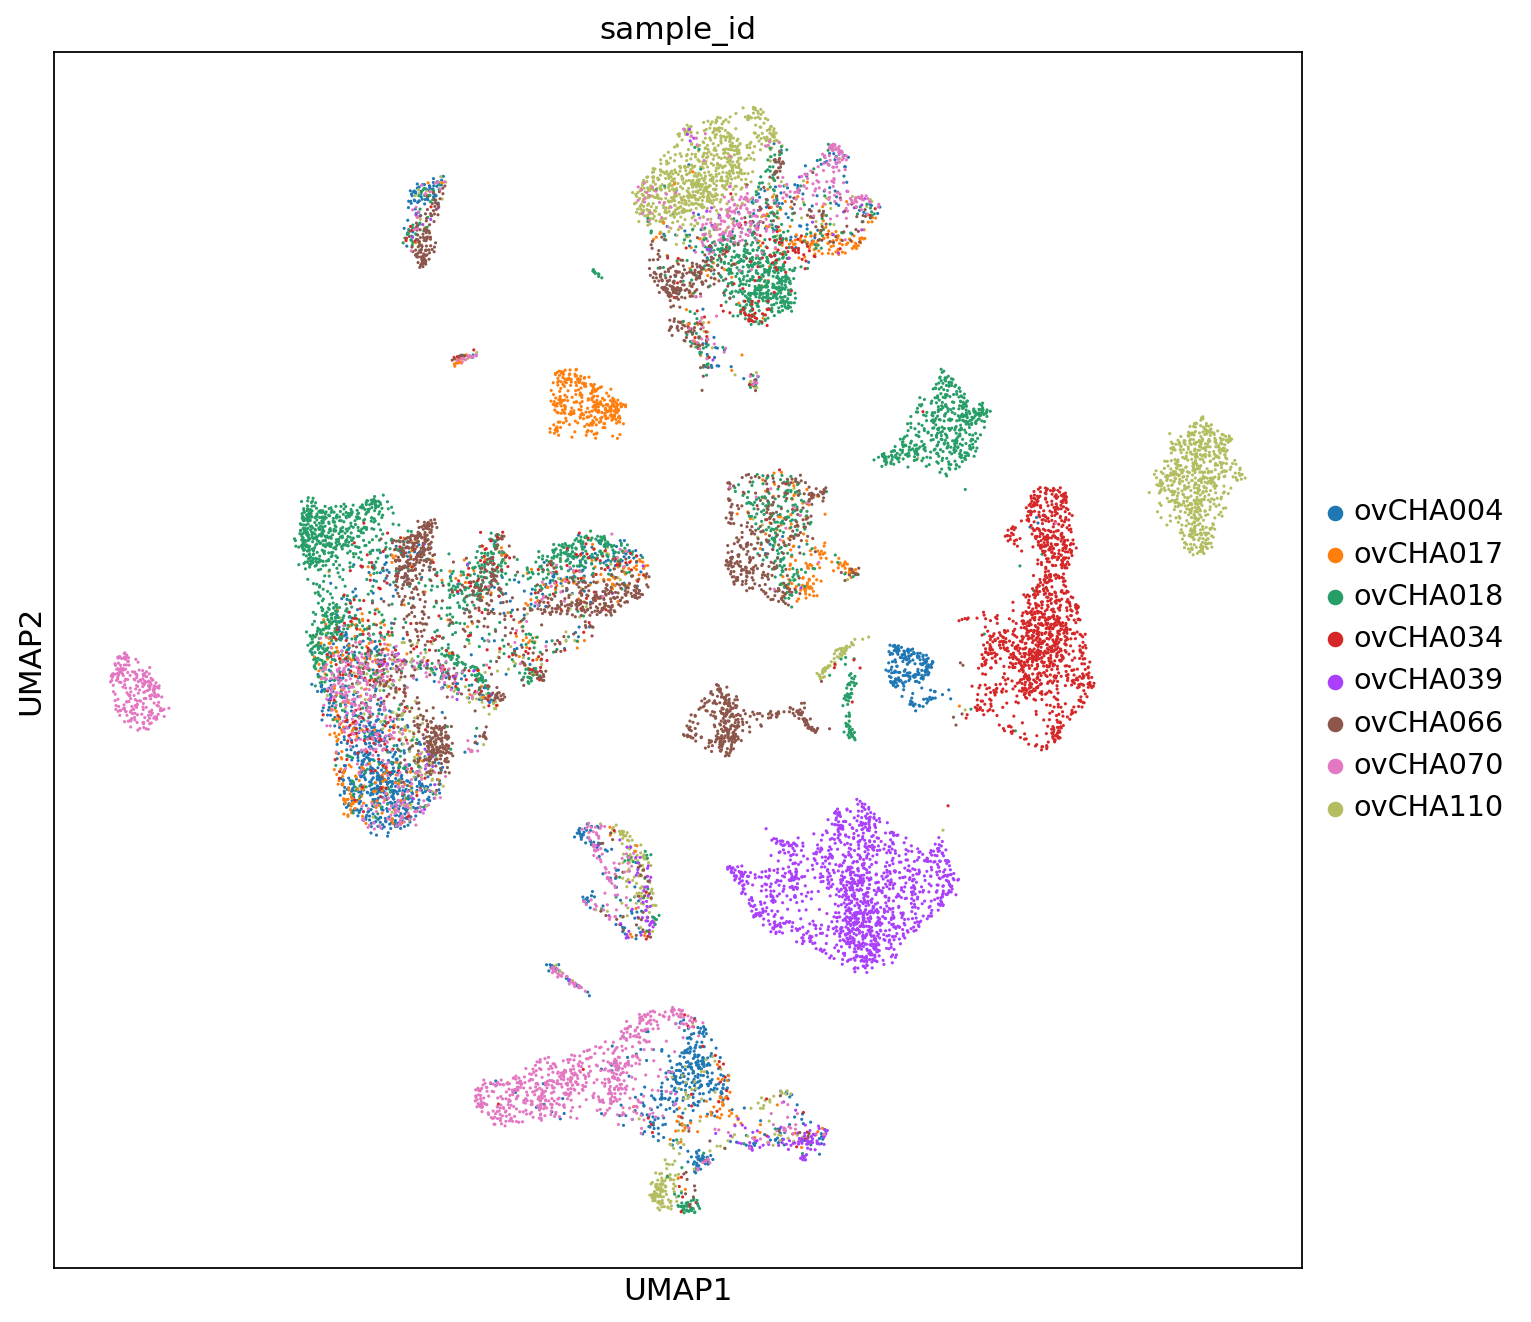

In [46]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata, color='sample_id')


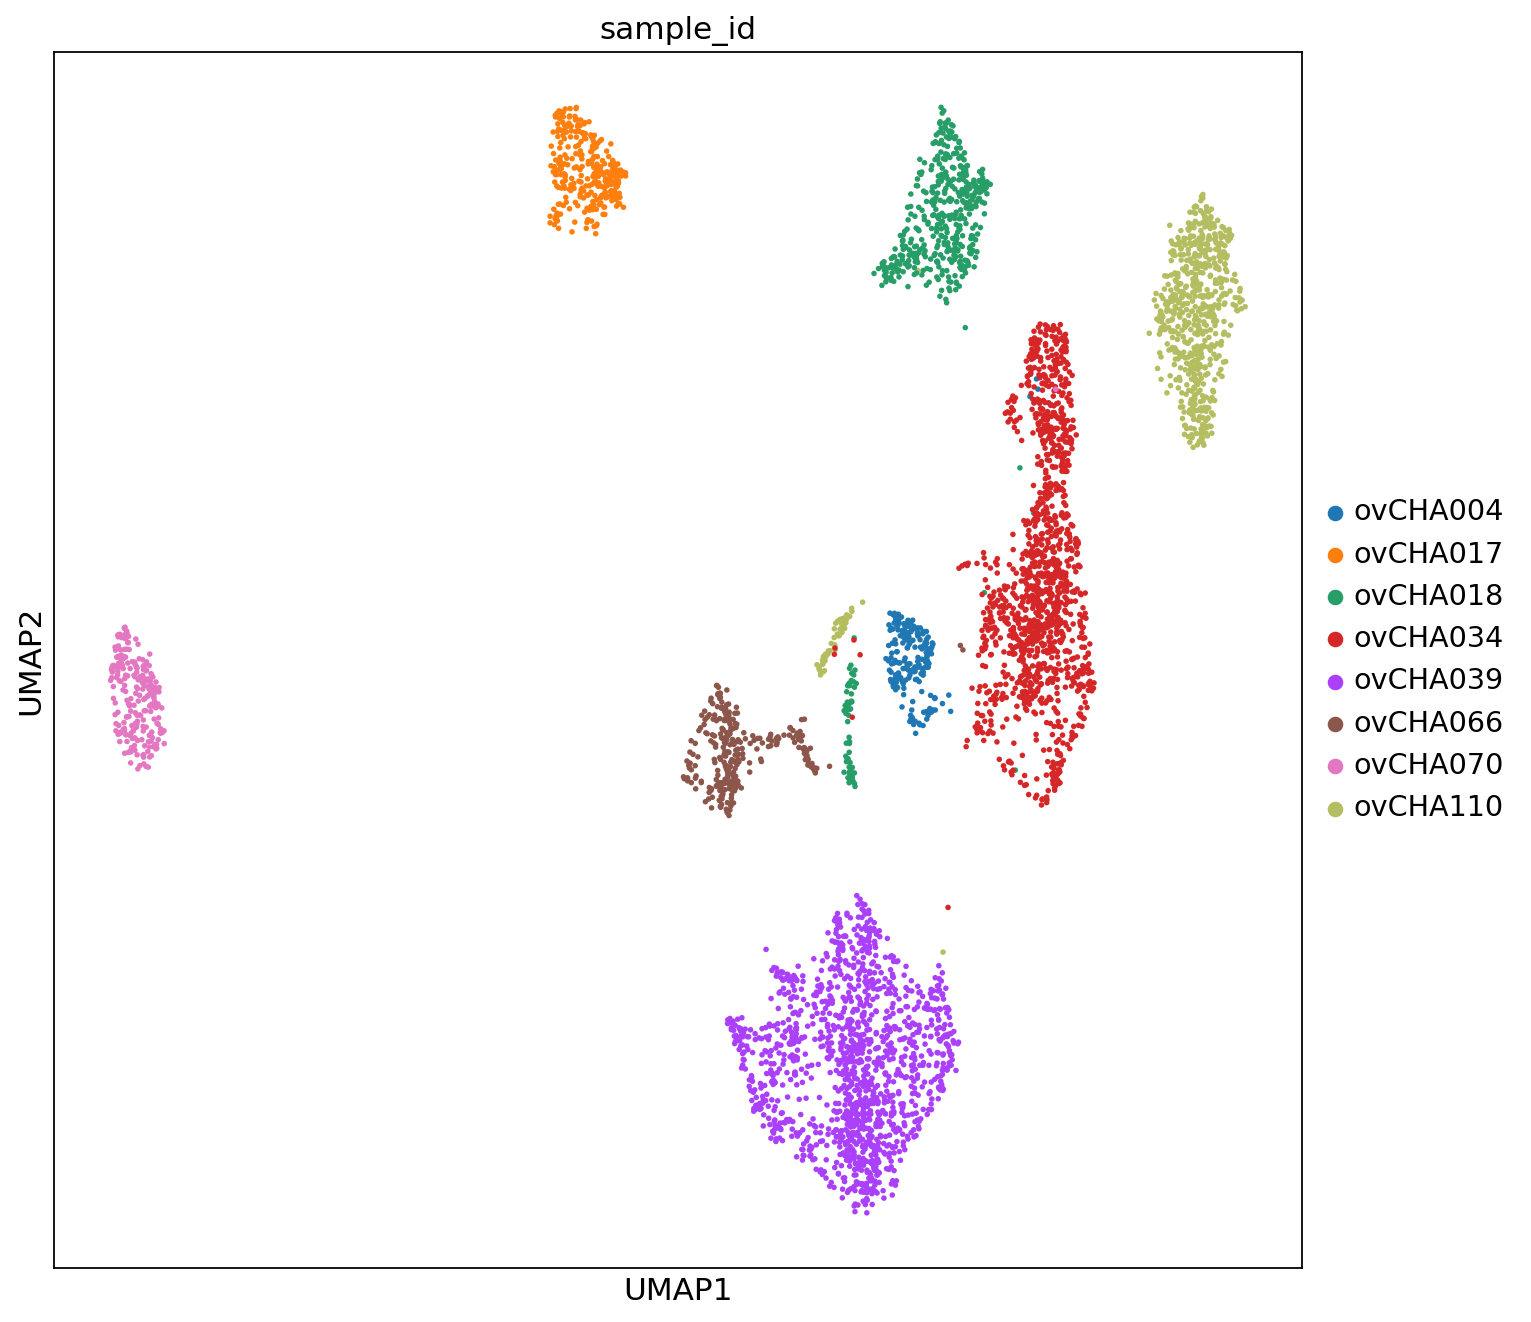

In [47]:
# plot by sample id
with rc_context({'figure.figsize': (10, 10)}):
    sc.pl.umap(all_adata[np.where(all_adata.obs.celltype_granular == "tumor")[0]], color='sample_id')
